In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.set_option('display.float_format', '{:.2f}'.format)
train_df = pd.read_csv("train.csv", parse_dates=['fecha'])

# train.csv

* **id** - 254099, **Entero**
* **titulo** - "condominio horizontal...", **string**
* **descripcion** - "lo que sea", **String**
* **tipoDePropiedad** - Apartamento-Casa en condominio, **debería ser tipo en enum**
* **direccion** - "av. mexico", **String**
* **ciudad** - "Benito Juarez", **String**
* **provincia** - "Distrito Federal", **String**
* **metrostotales** Metros totales de la propiedad, **Int**
* **metroscubiertos** Metros cubiertos de la propiedad, **Int**
* **antiguedad** - 10.0, Años **Decimal**
* **habitaciones** - 2.0, **Decimal**
* **garages** -  1.0, **Decimal**
* **idZona** - 23533.0, **Decimal**
* **lat** - 19.310205, **muchos numeros después de la coma**
* **ing** - -99.227655, **esto es la long**
* **fecha** - 2015-08-23 00:00:00, es un **datetime**
* **gimnasio** - 1.0 o 0.0, **verdadero o falso**
* **usosMultiples** - 1.0 o 0.0, **verdadero o falso**
* **piscina** - 1.0 o 0.0, **verdadero o falso**
* **escuelasCercanas** - 1.0 o 0.0, **verdadero o falso**
* **precio** - 2273000.0, en pesos Mexicanos

In [320]:
train_df.dtypes

id                                     int64
titulo                                object
descripcion                           object
tipodepropiedad                       object
direccion                             object
ciudad                                object
provincia                             object
antiguedad                           float64
habitaciones                         float64
garages                              float64
banos                                float64
metroscubiertos                      float64
metrostotales                        float64
idzona                               float64
lat                                  float64
lng                                  float64
fecha                         datetime64[ns]
gimnasio                             float64
usosmultiples                        float64
piscina                              float64
escuelascercanas                     float64
centroscomercialescercanos           float64
precio    

# ---------------------------------------------

Voy a filtrar todo lo que no sea una **Casa**

In [321]:
casas = train_df.loc[train_df["tipodepropiedad"] == "Casa"]
casas.shape

(141717, 23)

Voy a ver si encuentro algun atributo donde haya cantidades parejas, y ver si hay alguna diferencia notable en los precios

## ----------------------------------------------------------------------------------------------

## Precios para casas según caracteristicas
### Voy a probar filtrando y agrupando por las distintas caracteristicas comparando entre casas

* ### Piscina (diferencia de cantidades muy grande)

In [322]:
casaPrecioPiscina = casas.iloc[:, [5, 19,22]]
casaPrecioPiscina["piscina"] = casaPrecioPiscina["piscina"].map(lambda x : "Tiene piscina" if x == 1 else "No tiene piscina")
casaPrecioPiscina.head()

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ciudad,piscina,precio
2,Tonalá,No tiene piscina,1200000.00
3,Zinacantepec,No tiene piscina,650000.00
6,Oaxaca de Juárez,No tiene piscina,1150000.00
7,Playa del Carmen,No tiene piscina,4200000.00
10,San Luis Potosí,No tiene piscina,488000.00


Text(0, 0.5, 'Cantidad')

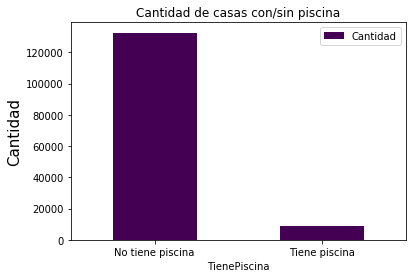

In [323]:
casasConPiscinaCount = casaPrecioPiscina.groupby(casaPrecioPiscina["piscina"]).agg({"count"}).reset_index()
casasConPiscinaCount = casasConPiscinaCount.iloc[: ,[0, 2]]
casasConPiscinaCount.columns = ["TienePiscina", "Cantidad"]
casasConPiscinaCount.plot.bar(x="TienePiscina", y="Cantidad", rot=0, title = "Cantidad de casas con/sin piscina",colormap='viridis').set_ylabel("Cantidad", fontsize=15)

Text(0.5, 1.0, 'Precios de casas con y sin piscina')

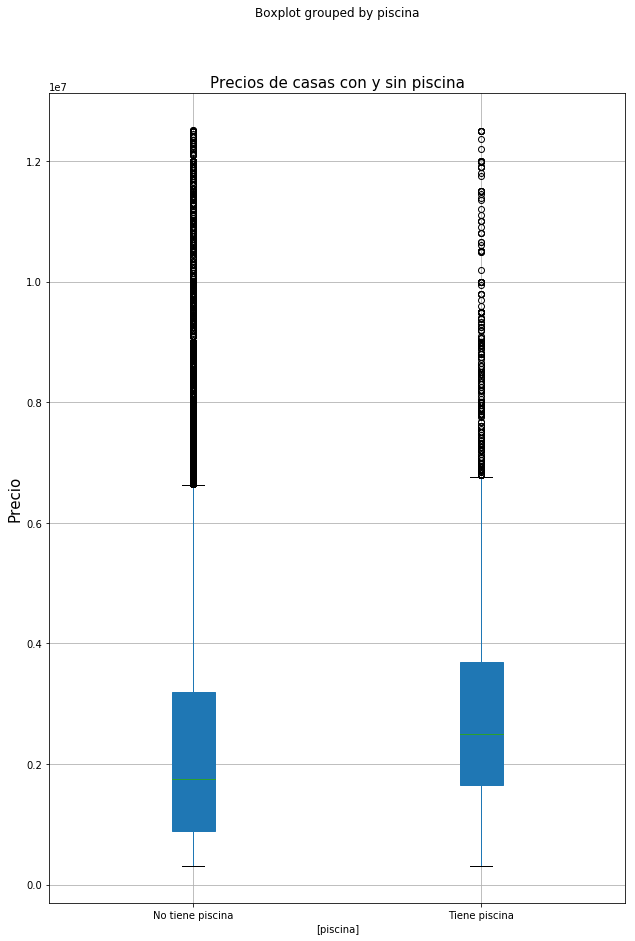

In [324]:
casaPrecioPiscinaBoxPlot = casaPrecioPiscina.boxplot(column=["precio"],patch_artist=True, figsize=(10,15), by=["piscina"])
casaPrecioPiscinaBoxPlot.set_ylabel("Precio", fontsize=15)
casaPrecioPiscinaBoxPlot.set_title("Precios de casas con y sin piscina", fontsize=15)

Aunque haga un boxplot, la diferencia de cantidad de casas para un grupo y otro es muy grande, creo que no es comparable

Quiero ver si esta diferencia es visible si agrupo por ciudades. Es decir, demuestro que hay una diferencia entre el promedio de precios de cada grupo (con o sin Piscina) en cada ciudad comparandose en si misma.

Algunas ciudades parece que no tienen casas con piscina publicadas, suena algo lógico pero no confio tanto

In [325]:
casaPrecioPiscina.loc[(casaPrecioPiscina["ciudad"] == "Abasolo") & (casaPrecioPiscina["piscina"] == "Tiene piscina")]

,ciudad,piscina,precio


Parece que no hay o son null los valores para estos casos

In [326]:
casaPrecioPiscinaCiudad = casaPrecioPiscina.groupby(["ciudad", "piscina"]).agg({"precio": "mean"}).reset_index()
casaPrecioPiscinaCiudad = casaPrecioPiscinaCiudad.pivot(index='ciudad', columns='piscina', values='precio')
casaPrecioPiscinaCiudad.columns = ["No tiene Piscina", "Tiene piscina"]
casaPrecioPiscinaCiudad = casaPrecioPiscinaCiudad.reset_index()
casaPrecioPiscinaCiudad.head()

,ciudad,No tiene Piscina,Tiene piscina
0,Abasolo,1651525.00,nan
1,Abejones,2500000.00,nan
2,Acajete,3662000.00,nan
3,Acambay,1133333.33,nan
4,Acapulco de Juárez,1839658.29,2308045.74


**Voy a ver que sucede con la diferencia de promedios de precios entre ambos grupos dentro de la misma ciudad**

In [327]:
casaPrecioPiscinaCiudad["priceMeanDifference"] = np.subtract(casaPrecioPiscinaCiudad['Tiene piscina'], casaPrecioPiscinaCiudad['No tiene Piscina'])
casaPrecioPiscinaCiudad.head()

,ciudad,No tiene Piscina,Tiene piscina,priceMeanDifference
0,Abasolo,1651525.00,nan,nan
1,Abejones,2500000.00,nan,nan
2,Acajete,3662000.00,nan,nan
3,Acambay,1133333.33,nan,nan
4,Acapulco de Juárez,1839658.29,2308045.74,468387.45


Text(0, 0.5, 'Diferencia entre promedio de precio entre ambos grupos')

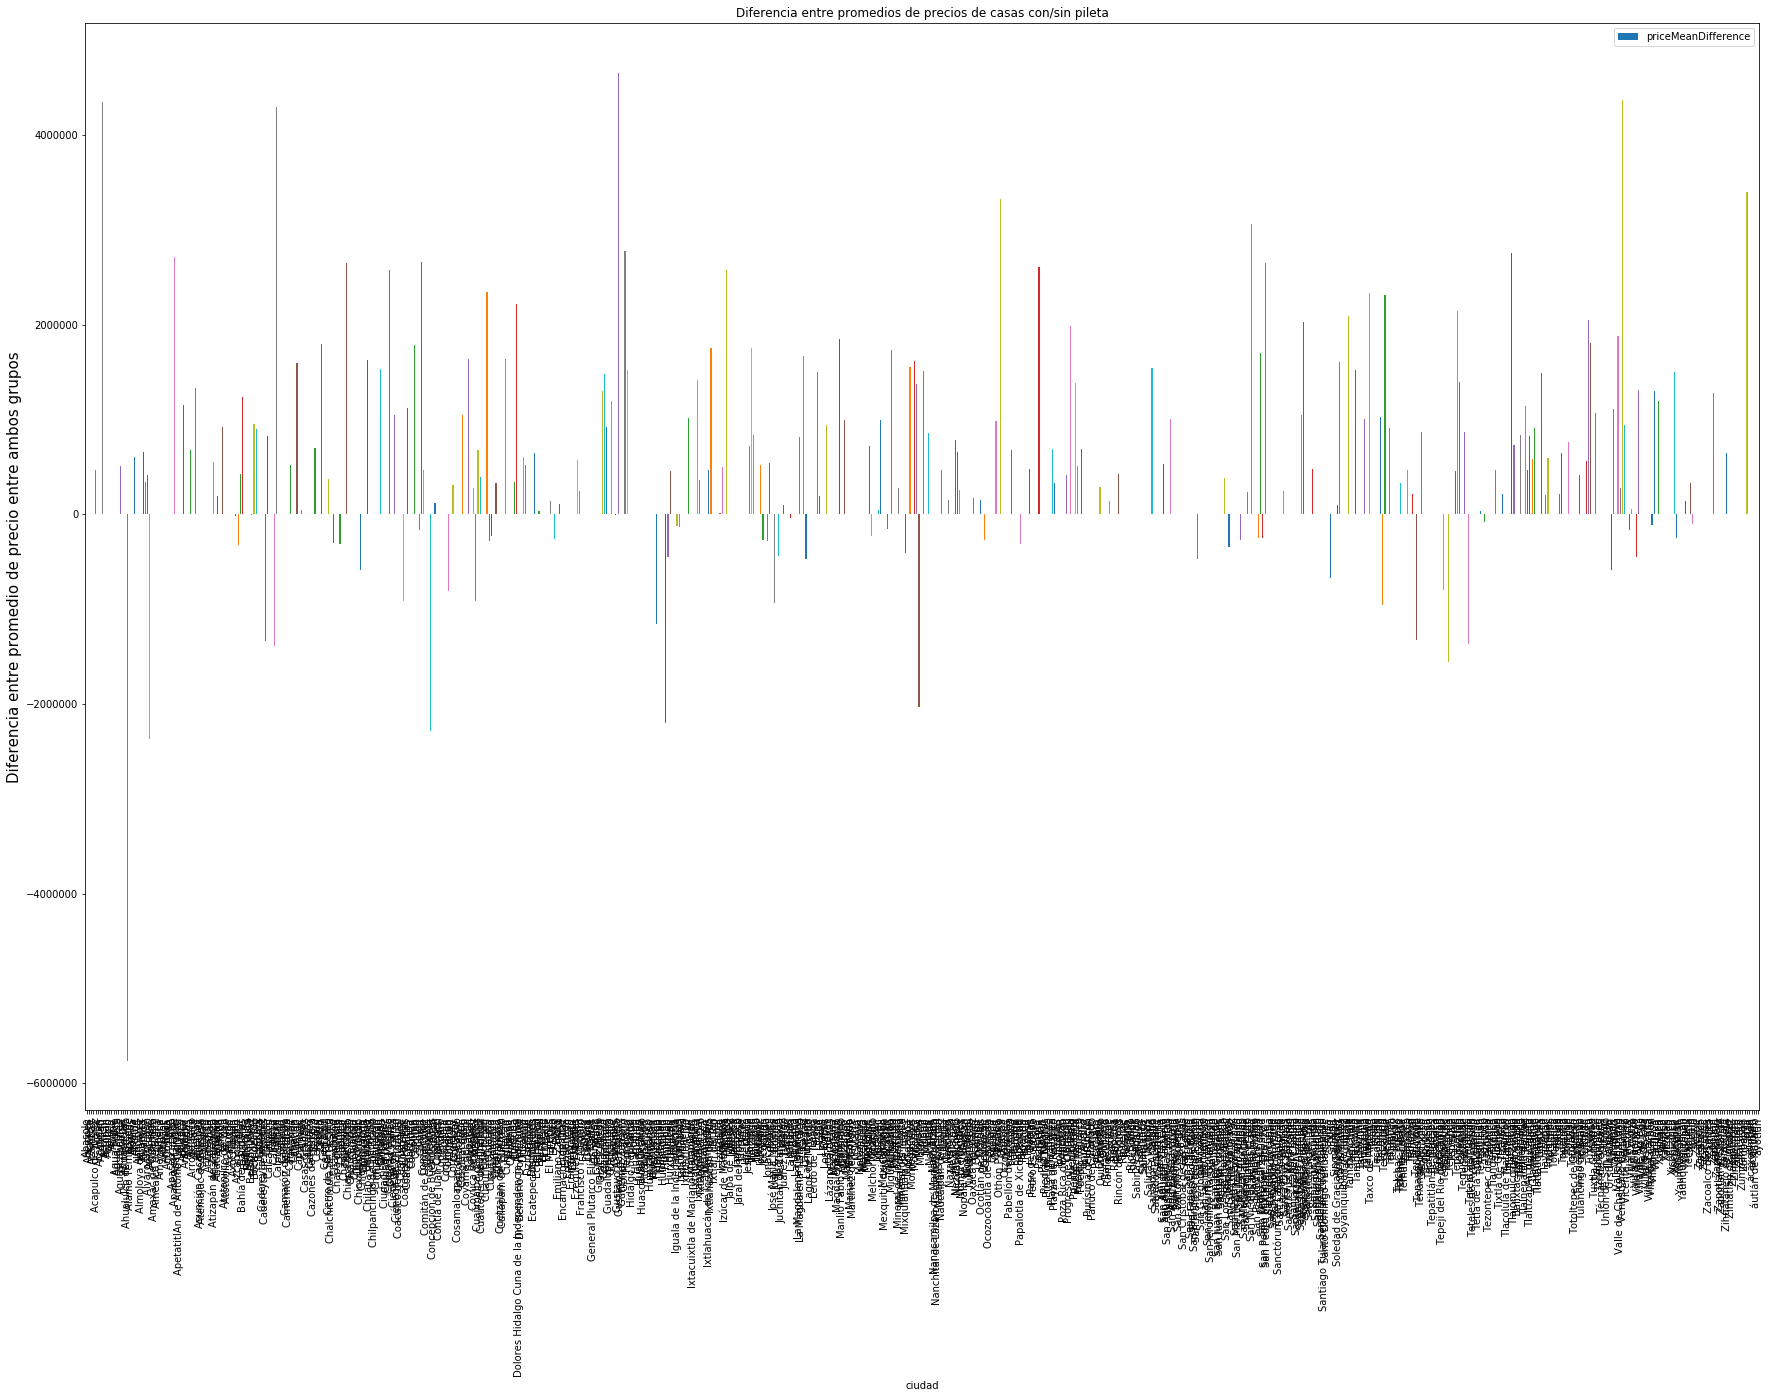

In [328]:
casaPrecioPiscinaCiudad.plot.bar(x='ciudad', y='priceMeanDifference', rot=90,figsize=(30,20), title="Diferencia entre promedios de precios de casas con/sin pileta").set_ylabel("Diferencia entre promedio de precio entre ambos grupos", fontsize=15)

**Voy a ver que sucede a medida que la brecha entre ambos grupos se achica**

In [329]:
casaPiscinaCount = casaPrecioPiscina.groupby(["ciudad", "piscina"]).agg({"precio": "count"}).reset_index()
casaPiscinaCount.columns = ["ciudad", "piscina", "count"]
casaPiscinaCount = casaPiscinaCount.pivot(index='ciudad', columns='piscina', values='count')
casaPiscinaCount.columns = ["countSinPiscina", "countConPiscina"]
casaPiscinaCount = casaPiscinaCount.reset_index()
#casaPiscinaCount = casaPiscinaCount.loc[casaPiscinaCount["countSinPiscina"] + casaPiscinaCount["countConPiscina"] > 500]
display(casaPiscinaCount.head())
grupoConYSinPiscina = casaPiscinaCount.merge(casaPrecioPiscinaCiudad, on="ciudad")
display(grupoConYSinPiscina.head())

,ciudad,countSinPiscina,countConPiscina
0,Abasolo,4.00,nan
1,Abejones,1.00,nan
2,Acajete,5.00,nan
3,Acambay,6.00,nan
4,Acapulco de Juárez,308.00,191.00


,ciudad,countSinPiscina,countConPiscina,No tiene Piscina,Tiene piscina,priceMeanDifference
0,Abasolo,4.00,nan,1651525.00,nan,nan
1,Abejones,1.00,nan,2500000.00,nan,nan
2,Acajete,5.00,nan,3662000.00,nan,nan
3,Acambay,6.00,nan,1133333.33,nan,nan
4,Acapulco de Juárez,308.00,191.00,1839658.29,2308045.74,468387.45


**Creo nueva columna con la diferencia entre cantidades**

In [330]:
grupoConYSinPiscina["groupCountDifference"] = (grupoConYSinPiscina["countSinPiscina"] - grupoConYSinPiscina["countConPiscina"]).abs()
grupoConYSinPiscina["totalCount"] = grupoConYSinPiscina["countSinPiscina"] + grupoConYSinPiscina["countConPiscina"]
grupoConYSinPiscina.head()

,ciudad,countSinPiscina,countConPiscina,No tiene Piscina,Tiene piscina,priceMeanDifference,groupCountDifference,totalCount
0,Abasolo,4.00,nan,1651525.00,nan,nan,nan,nan
1,Abejones,1.00,nan,2500000.00,nan,nan,nan,nan
2,Acajete,5.00,nan,3662000.00,nan,nan,nan,nan
3,Acambay,6.00,nan,1133333.33,nan,nan,nan,nan
4,Acapulco de Juárez,308.00,191.00,1839658.29,2308045.74,468387.45,117.00,499.00


In [331]:
grupoConYSinPiscina = grupoConYSinPiscina.sort_values(by= "groupCountDifference")

Text(0.5, 1.0, 'Diferencia entre promedios de precios de casas con/sin pileta a medida que crece la brecha entre grupos')

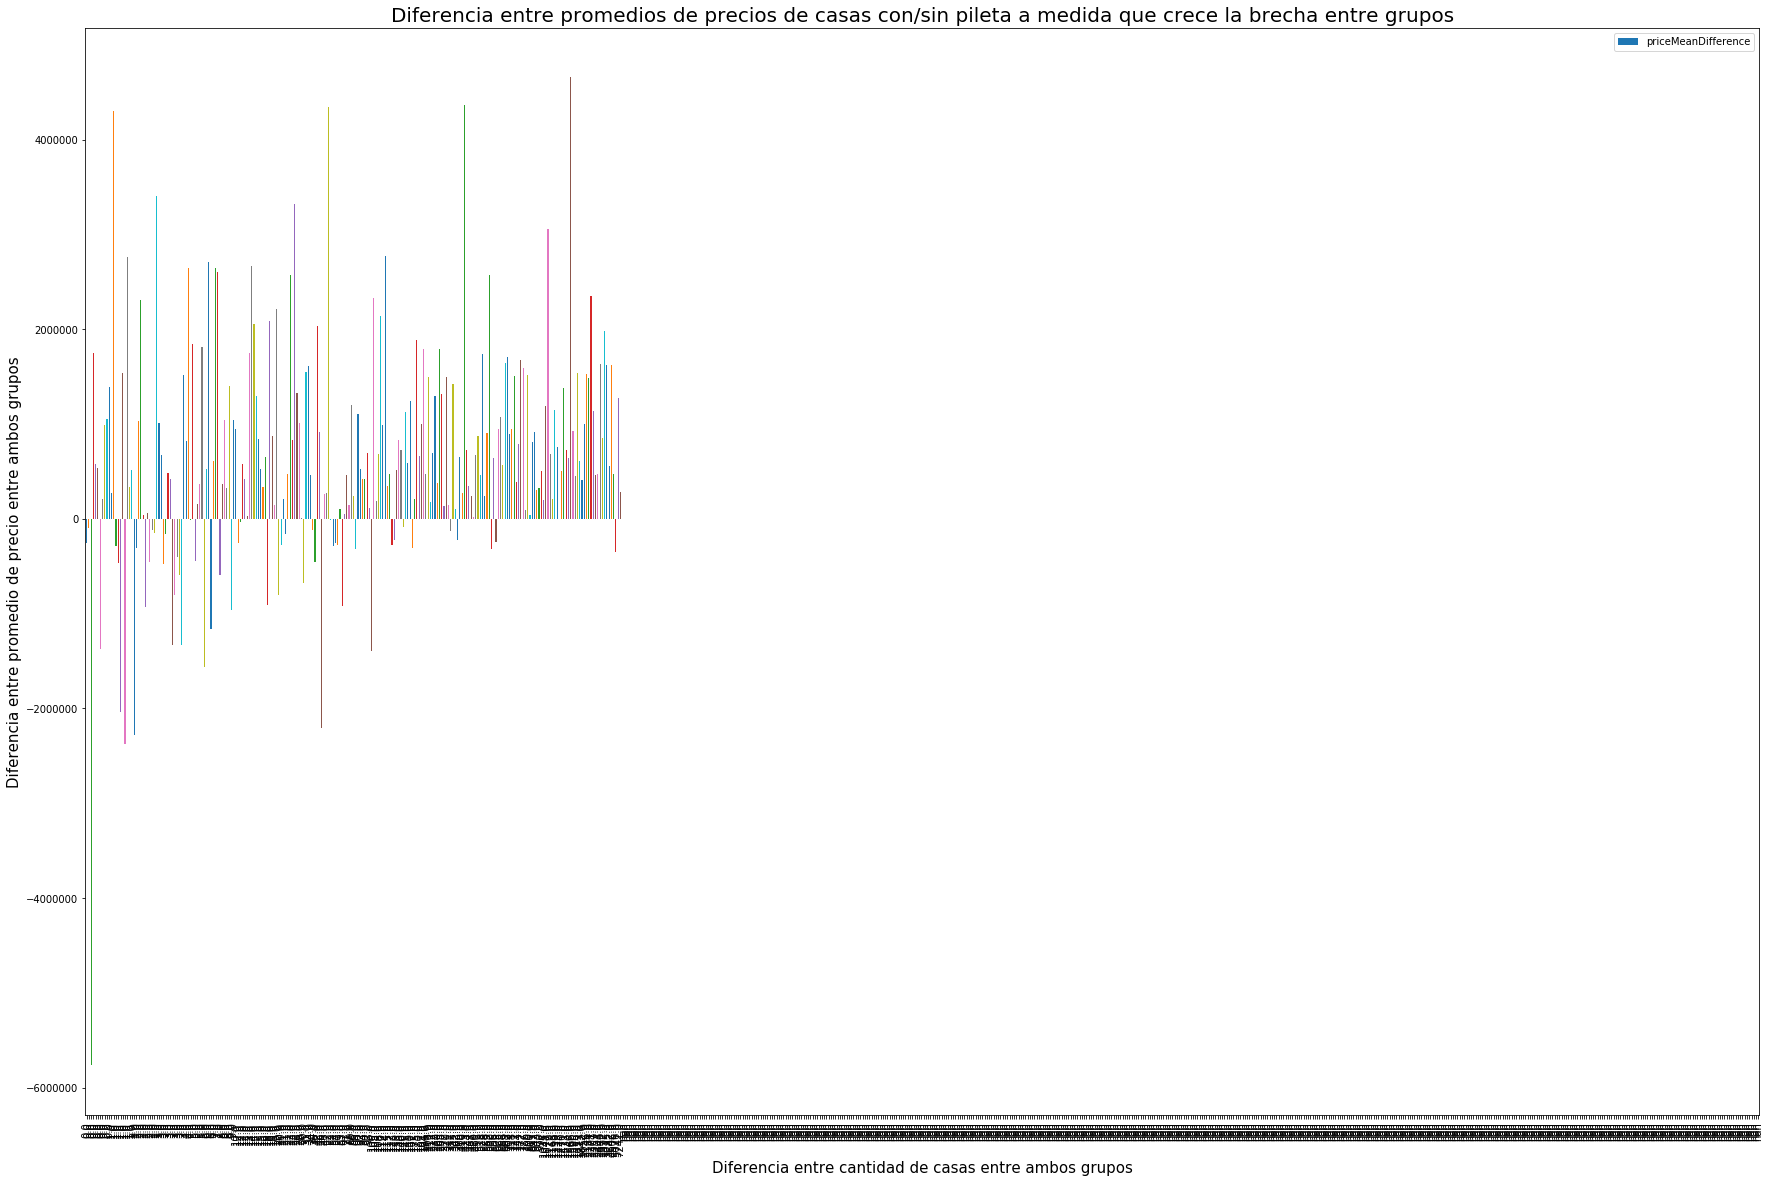

In [332]:
countDifferencePriceDifferencePoolPlot = grupoConYSinPiscina.plot.bar(x='groupCountDifference', y='priceMeanDifference', rot=90,figsize=(30,20))
countDifferencePriceDifferencePoolPlot.set_ylabel("Diferencia entre promedio de precio entre ambos grupos", fontsize=15)
countDifferencePriceDifferencePoolPlot.set_xlabel("Diferencia entre cantidad de casas entre ambos grupos", fontsize=15)
countDifferencePriceDifferencePoolPlot.set_title("Diferencia entre promedios de precios de casas con/sin pileta a medida que crece la brecha entre grupos", fontsize=20)

In [333]:
grupoConYSinPiscina = grupoConYSinPiscina.sort_values(by= "totalCount")

Text(0.5, 1.0, 'Diferencia entre promedios de precios de casas con/sin pileta a medida que crece la cantidad de casas publicadas')

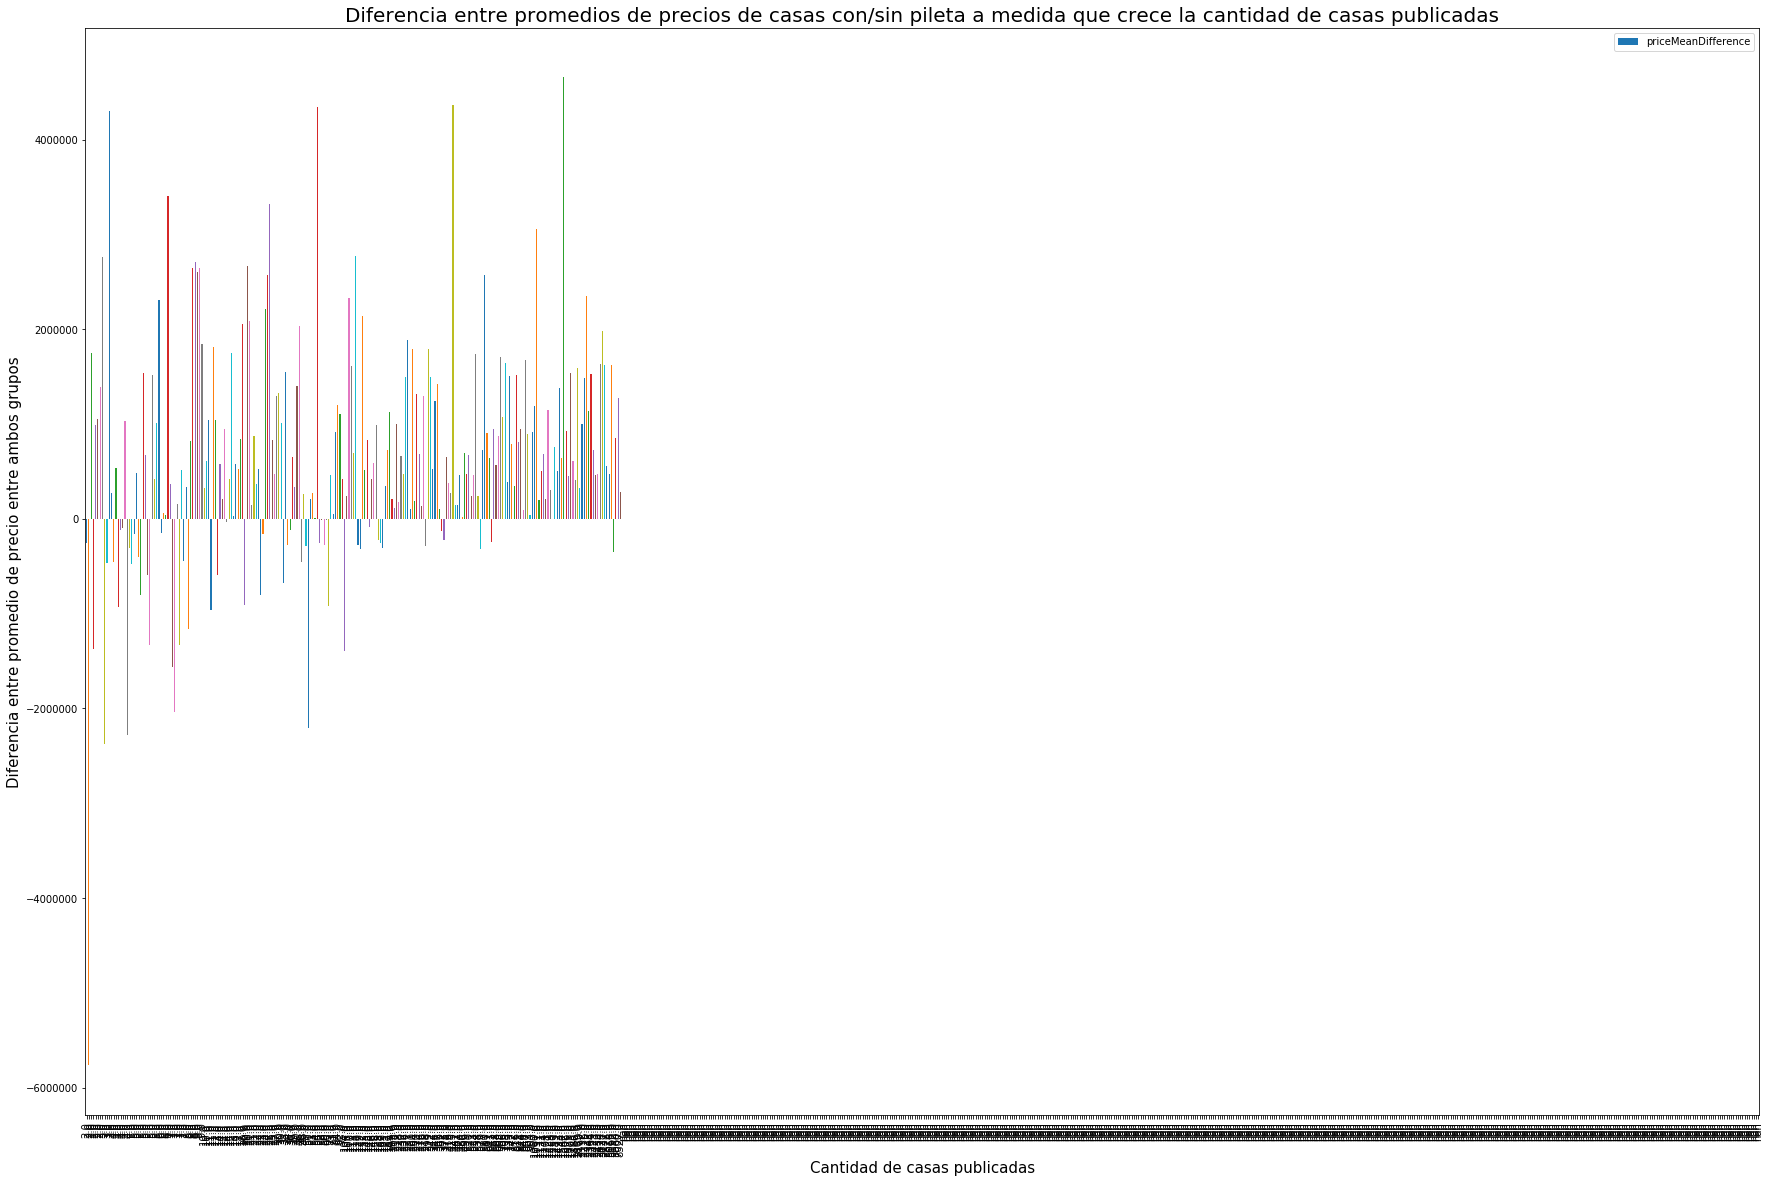

In [334]:
countDifferencePriceDifferencePoolPlot = grupoConYSinPiscina.plot.bar(x='totalCount', y='priceMeanDifference', rot=90,figsize=(30,20))
countDifferencePriceDifferencePoolPlot.set_ylabel("Diferencia entre promedio de precio entre ambos grupos", fontsize=15)
countDifferencePriceDifferencePoolPlot.set_xlabel("Cantidad de casas publicadas", fontsize=15)
countDifferencePriceDifferencePoolPlot.set_title("Diferencia entre promedios de precios de casas con/sin pileta a medida que crece la cantidad de casas publicadas", fontsize=20)

* ### Escuelas cercanas (cantidades parecidas, pero los precios son casi iguales)

In [335]:
casaPrecioEscuela = casas.iloc[:, [5, 20, 22]]
casaPrecioEscuela.head()

,ciudad,escuelascercanas,precio
2,Tonalá,0.00,1200000.00
3,Zinacantepec,1.00,650000.00
6,Oaxaca de Juárez,0.00,1150000.00
7,Playa del Carmen,0.00,4200000.00
10,San Luis Potosí,1.00,488000.00


Text(0, 0.5, 'Cantidad')

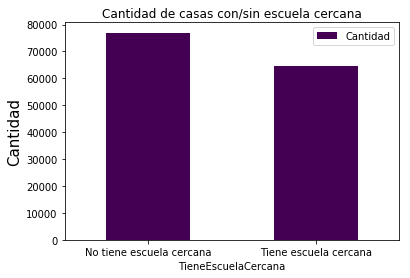

In [336]:
casasConEscuelaCercaCount = casaPrecioEscuela.groupby(casaPrecioEscuela["escuelascercanas"]).agg({"count"}).reset_index()
casasConEscuelaCercaCount = casasConEscuelaCercaCount.iloc[:, [0,1]]
casasConEscuelaCercaCount.columns = ["TieneEscuelaCercana", "Cantidad"]
casasConEscuelaCercaCount["TieneEscuelaCercana"] = casasConEscuelaCercaCount["TieneEscuelaCercana"].map(lambda x : "Tiene escuela cercana" if x == 1 else "No tiene escuela cercana")
casasConEscuelaCercaCount.plot.bar(x="TieneEscuelaCercana", y="Cantidad", rot=0, title = "Cantidad de casas con/sin escuela cercana",colormap='viridis').set_ylabel("Cantidad", fontsize=15)

Las cantidades son mucho más parecidas

In [337]:
casaPrecioEscuela["escuelascercanas"] = casaPrecioEscuela["escuelascercanas"].map(lambda x : "Tiene escuela cercana" if x == 1 else "No tiene escuela cercana")

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Precios de casas con y sin escuelas cercanas')

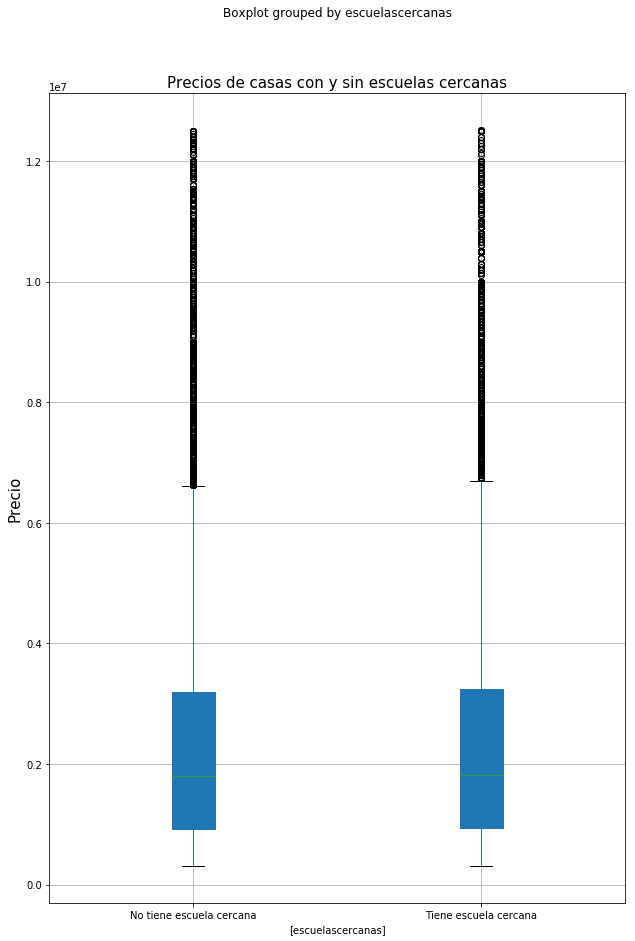

In [338]:
casaPrecioEscuelaBoxPlot = casaPrecioEscuela.boxplot(column=["precio"],patch_artist=True, figsize=(10,15), by=["escuelascercanas"])
casaPrecioEscuelaBoxPlot.set_ylabel("Precio", fontsize=15)
casaPrecioEscuelaBoxPlot.set_title("Precios de casas con y sin escuelas cercanas", fontsize=15)

In [339]:
casaPrecioEscuelaCiudad = casaPrecioEscuela.groupby(["ciudad", "escuelascercanas"]).agg({"precio": "mean"}).reset_index()
casaPrecioEscuelaCiudad = casaPrecioEscuelaCiudad.pivot(index='ciudad', columns='escuelascercanas', values='precio')
casaPrecioEscuelaCiudad.columns = ["No tiene escuela cercana", "Tiene escuela cercana"]
casaPrecioEscuelaCiudad = casaPrecioEscuelaCiudad.reset_index()
casaPrecioEscuelaCiudad = casaPrecioEscuelaCiudad.dropna()
casaPrecioEscuelaCiudad.head()

,ciudad,No tiene escuela cercana,Tiene escuela cercana
2,Acajete,3127500.00,5800000.00
3,Acambay,950000.00,1170000.00
4,Acapulco de Juárez,2378275.21,1714172.10
6,Acayucan,409488.00,380000.00
7,Acolman,754359.26,1115011.11


In [340]:
casaPrecioEscuelaCiudad["priceMeanDifference"] = np.subtract(casaPrecioEscuelaCiudad['Tiene escuela cercana'], casaPrecioEscuelaCiudad['No tiene escuela cercana'])
casaPrecioEscuelaCiudad.head()

,ciudad,No tiene escuela cercana,Tiene escuela cercana,priceMeanDifference
2,Acajete,3127500.00,5800000.00,2672500.00
3,Acambay,950000.00,1170000.00,220000.00
4,Acapulco de Juárez,2378275.21,1714172.10,-664103.11
6,Acayucan,409488.00,380000.00,-29488.00
7,Acolman,754359.26,1115011.11,360651.85


Text(0, 0.5, 'Diferencia entre promedio de precio entre ambos grupos')

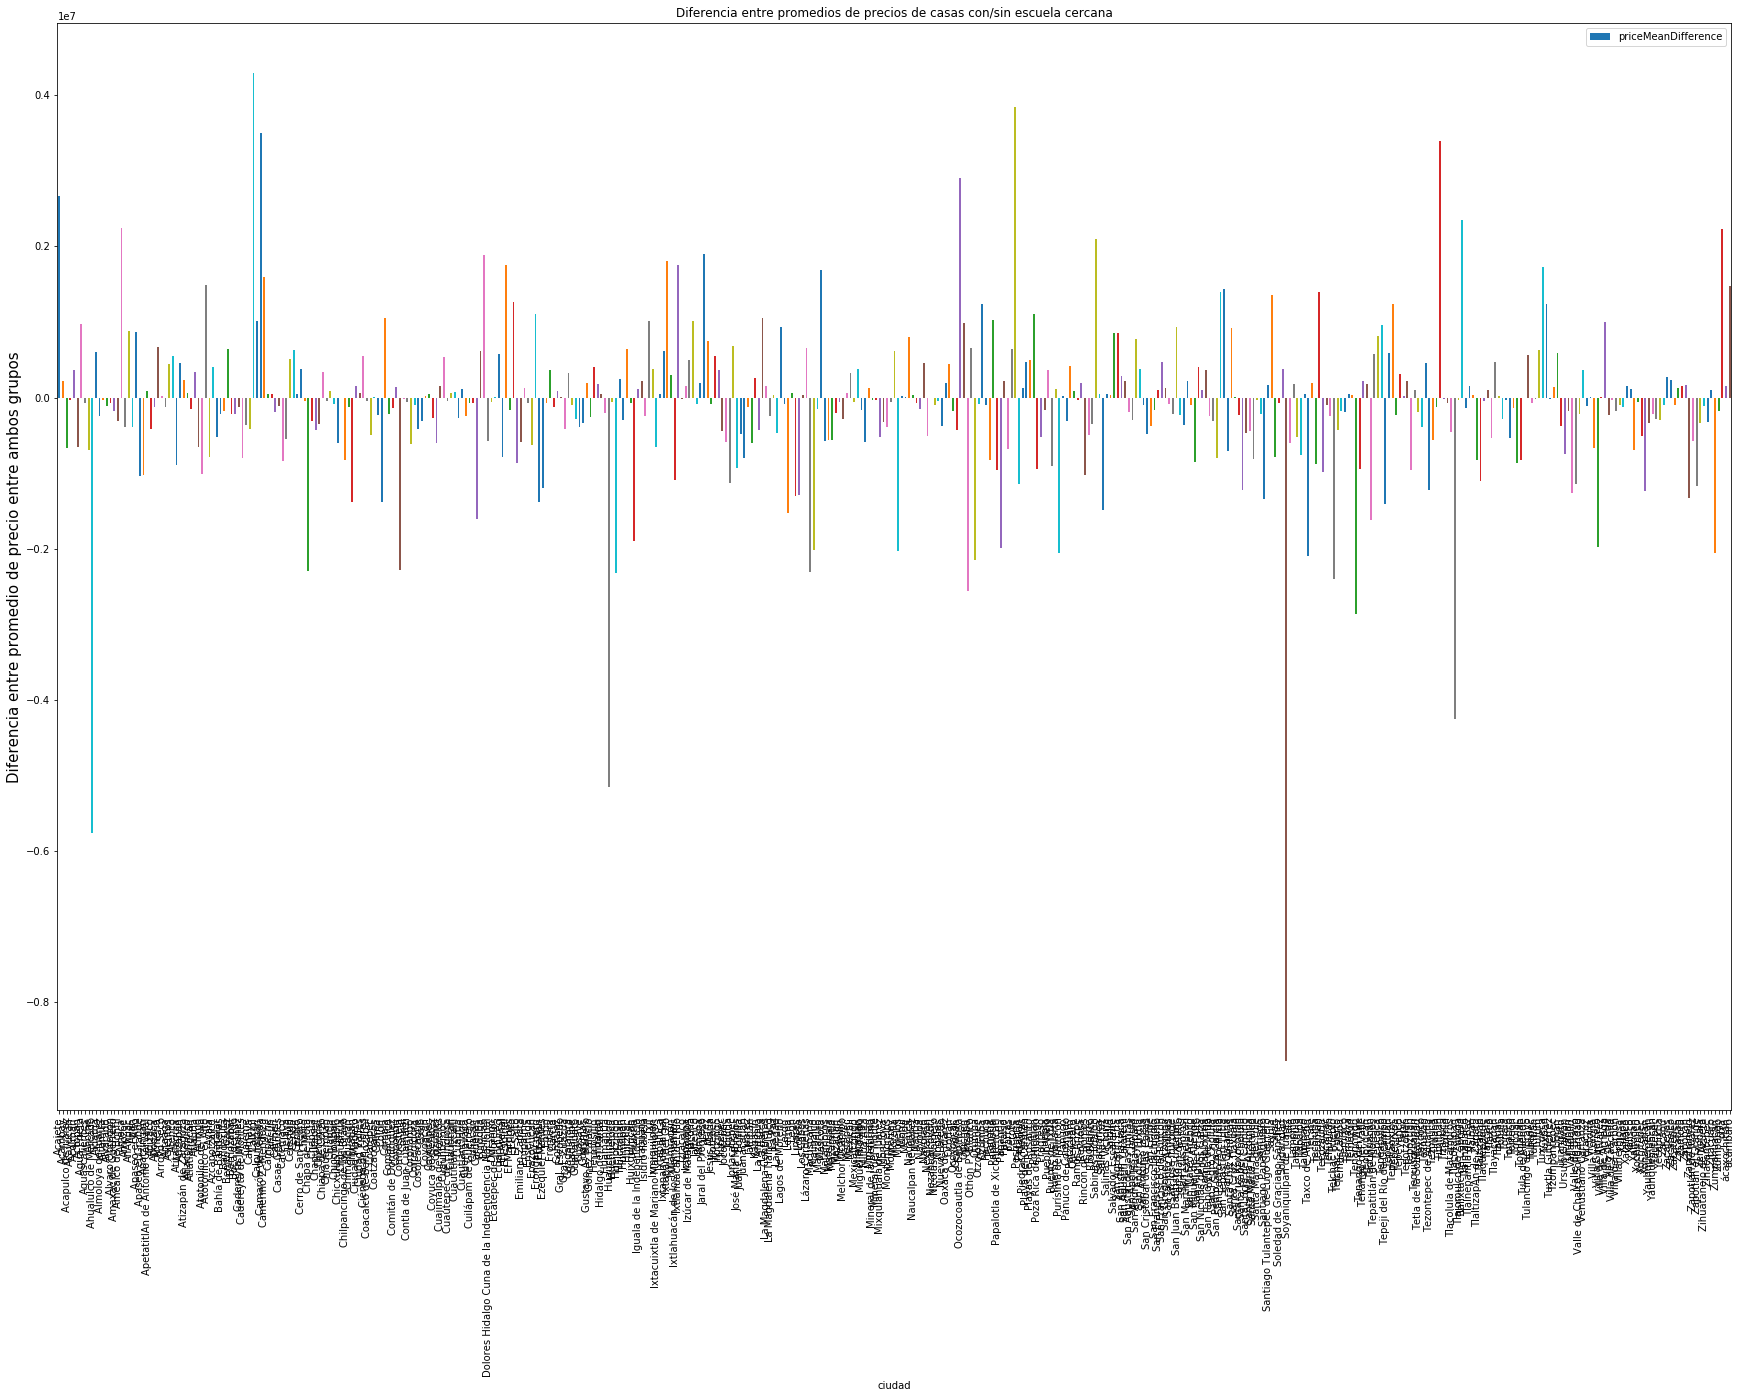

In [341]:
casaPrecioEscuelaCiudad.plot.bar(x='ciudad', y='priceMeanDifference', rot=90,figsize=(30,20), title="Diferencia entre promedios de precios de casas con/sin escuela cercana").set_ylabel("Diferencia entre promedio de precio entre ambos grupos", fontsize=15)

In [359]:
casaEscuelaCount = casaPrecioEscuela.groupby(["ciudad", "escuelascercanas"]).agg({"precio": "count"}).reset_index()
casaEscuelaCount.columns = ["ciudad", "escuelaCercana", "count"]
casaEscuelaCount = casaEscuelaCount.pivot(index='ciudad', columns='escuelaCercana', values='count')
casaEscuelaCount.columns = ["countSinEscuelaCercana", "countConEscuelaCercana"]
casaEscuelaCount = casaEscuelaCount.reset_index()
display(casaEscuelaCount.head())
grupoConYSinEscuelaCercana = casaEscuelaCount.merge(casaPrecioEscuelaCiudad, on="ciudad")
display(grupoConYSinEscuelaCercana.head())

,ciudad,countSinEscuelaCercana,countConEscuelaCercana
0,Abasolo,4.00,nan
1,Abejones,1.00,nan
2,Acajete,4.00,1.00
3,Acambay,1.00,5.00
4,Acapulco de Juárez,229.00,270.00


,ciudad,countSinEscuelaCercana,countConEscuelaCercana,No tiene escuela cercana,Tiene escuela cercana,priceMeanDifference
0,Acajete,4.00,1.00,3127500.00,5800000.00,2672500.00
1,Acambay,1.00,5.00,950000.00,1170000.00,220000.00
2,Acapulco de Juárez,229.00,270.00,2378275.21,1714172.10,-664103.11
3,Acayucan,1.00,1.00,409488.00,380000.00,-29488.00
4,Acolman,27.00,27.00,754359.26,1115011.11,360651.85


In [361]:
grupoConYSinEscuelaCercana["groupCountDifference"] = (grupoConYSinEscuelaCercana["countSinEscuelaCercana"] - grupoConYSinEscuelaCercana["countConEscuelaCercana"]).abs()
grupoConYSinEscuelaCercana["totalCount"] = grupoConYSinEscuelaCercana["countSinEscuelaCercana"] + grupoConYSinEscuelaCercana["countConEscuelaCercana"]
grupoConYSinEscuelaCercana.head()

,ciudad,countSinEscuelaCercana,countConEscuelaCercana,No tiene escuela cercana,Tiene escuela cercana,priceMeanDifference,groupCountDifference,totalCount
0,Acajete,4.00,1.00,3127500.00,5800000.00,2672500.00,3.00,5.00
1,Acambay,1.00,5.00,950000.00,1170000.00,220000.00,4.00,6.00
2,Acapulco de Juárez,229.00,270.00,2378275.21,1714172.10,-664103.11,41.00,499.00
3,Acayucan,1.00,1.00,409488.00,380000.00,-29488.00,0.00,2.00
4,Acolman,27.00,27.00,754359.26,1115011.11,360651.85,0.00,54.00


In [362]:
grupoConYSinEscuelaCercana = grupoConYSinEscuelaCercana.sort_values(by= "groupCountDifference")

**Grafico ordenando por diferencia entre grupos**

Text(0.5, 1.0, 'Diferencia entre promedios de precios de casas con/sin escuela cercana a medida que crece la brecha entre grupos')

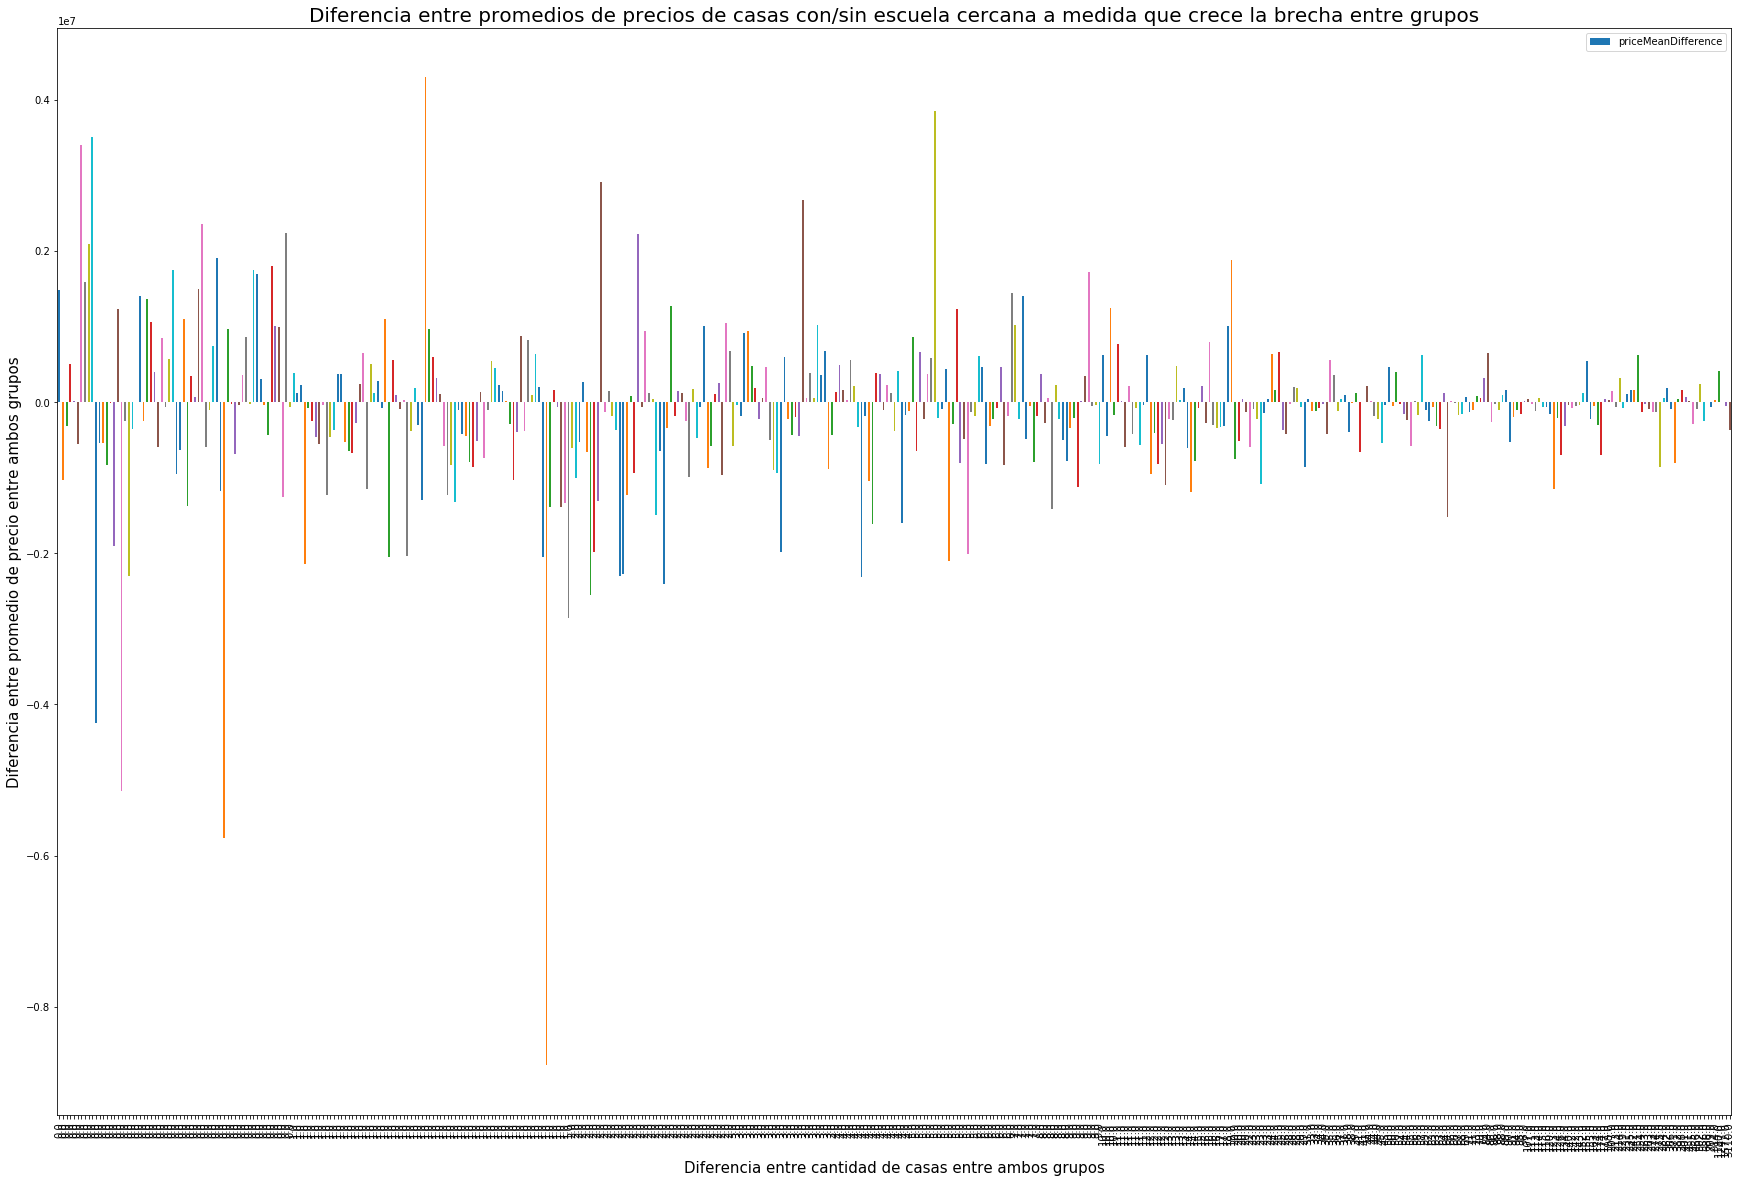

In [364]:
countDifferencePriceDifferenceSchoolPlot = grupoConYSinEscuelaCercana.plot.bar(x='groupCountDifference', y='priceMeanDifference', rot=90,figsize=(30,20))
countDifferencePriceDifferenceSchoolPlot.set_ylabel("Diferencia entre promedio de precio entre ambos grupos", fontsize=15)
countDifferencePriceDifferenceSchoolPlot.set_xlabel("Diferencia entre cantidad de casas entre ambos grupos", fontsize=15)
countDifferencePriceDifferenceSchoolPlot.set_title("Diferencia entre promedios de precios de casas con/sin escuela cercana a medida que crece la brecha entre grupos", fontsize=20)

Text(0.5, 1.0, 'Diferencia entre promedios de precios de casas con/sin escuela cercana a medida que crece la brecha entre grupos')

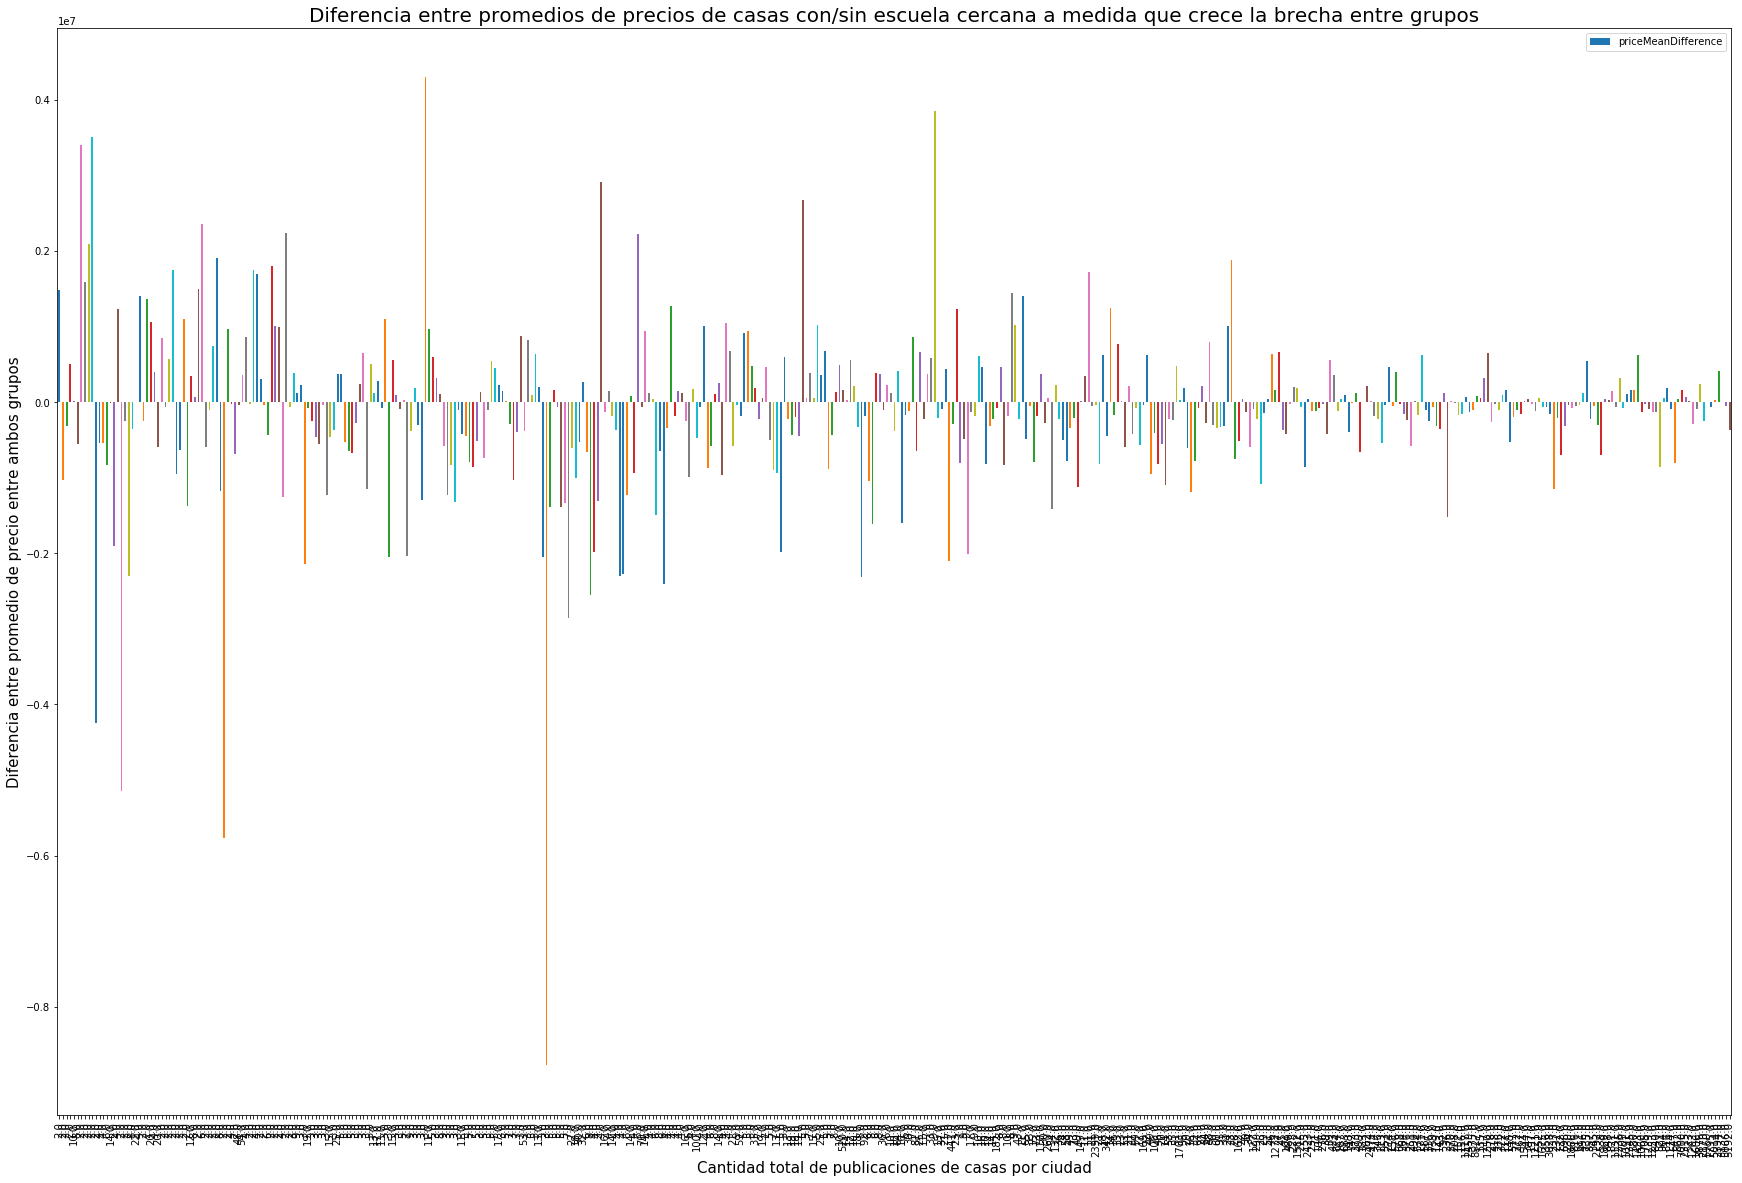

In [365]:
countDifferencePriceDifferenceSchoolPlot = grupoConYSinEscuelaCercana.plot.bar(x='totalCount', y='priceMeanDifference', rot=90,figsize=(30,20))
countDifferencePriceDifferenceSchoolPlot.set_ylabel("Diferencia entre promedio de precio entre ambos grupos", fontsize=15)
countDifferencePriceDifferenceSchoolPlot.set_xlabel("Cantidad total de publicaciones de casas por ciudad", fontsize=15)
countDifferencePriceDifferenceSchoolPlot.set_title("Diferencia entre promedios de precios de casas con/sin escuela cercana a medida que crece la brecha entre grupos", fontsize=20)

* ### Gimnasio (Inutil como el primero)

In [342]:
casaPrecioGimnasio = casas.iloc[:, [5,17,22]]
casaPrecioGimnasio = casaPrecioGimnasio.loc[casaPrecioGimnasio["ciudad"] == "Zapopan"]
casaPrecioGimnasio.head()

,ciudad,gimnasio,precio
14,Zapopan,0.00,5300000.00
120,Zapopan,0.00,990000.00
181,Zapopan,0.00,980000.00
202,Zapopan,0.00,700000.00
203,Zapopan,0.00,623000.00


Text(0, 0.5, 'Cantidad')

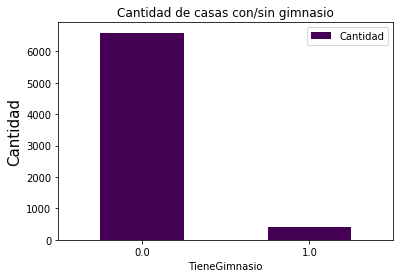

In [343]:
casasConGimnasioCount = casaPrecioGimnasio.groupby(casaPrecioGimnasio["gimnasio"]).agg({"count"}).reset_index()
casasConGimnasioCount = casasConGimnasioCount.iloc[:, [0,1]]
casasConGimnasioCount.columns = ["TieneGimnasio", "Cantidad"]
casasConGimnasioCount.plot.bar(x="TieneGimnasio", y="Cantidad", rot=0, title = "Cantidad de casas con/sin gimnasio",colormap='viridis').set_ylabel("Cantidad", fontsize=15)

Era obvio igual que iba a pasar esto...

* ### Usos multiples (Ni lo hago porque esto es más de edificio)

## Precio de casas por ciudad 
### Voy a ver las cantidades para ver si hay cosas comparables

In [344]:
casaPrecioCiudad = casas.iloc[:, [5,22]]
casaPrecioCiudad.head()

,ciudad,precio
2,Tonalá,1200000.00
3,Zinacantepec,650000.00
6,Oaxaca de Juárez,1150000.00
7,Playa del Carmen,4200000.00
10,San Luis Potosí,488000.00


In [345]:
groupCiudadCant = casaPrecioCiudad.groupby(casaPrecioCiudad["ciudad"]).agg("count").reset_index()
groupCiudadCant.columns = ["ciudad", "cantidad"]
groupCiudadCant.head()

,ciudad,cantidad
0,Abasolo,4
1,Abejones,1
2,Acajete,5
3,Acambay,6
4,Acapulco de Juárez,499


In [346]:
groupCiudadCant.shape

(740, 2)

Osea, hay 392 ciudades distintas (limpie nans), buenisimo, el grafico de abajo sale perfecto entonces

**No se entiende nada**, pero parece que hay muchas que tienen **muy pocas publicaciones** y otras bastantes más, voy a ver como las encuentro.

Mejor, pero quiero poder leer los nombres a simple vista, luego veo que hacer con todas las ciudades

Text(0, 0.5, 'Cantidad')

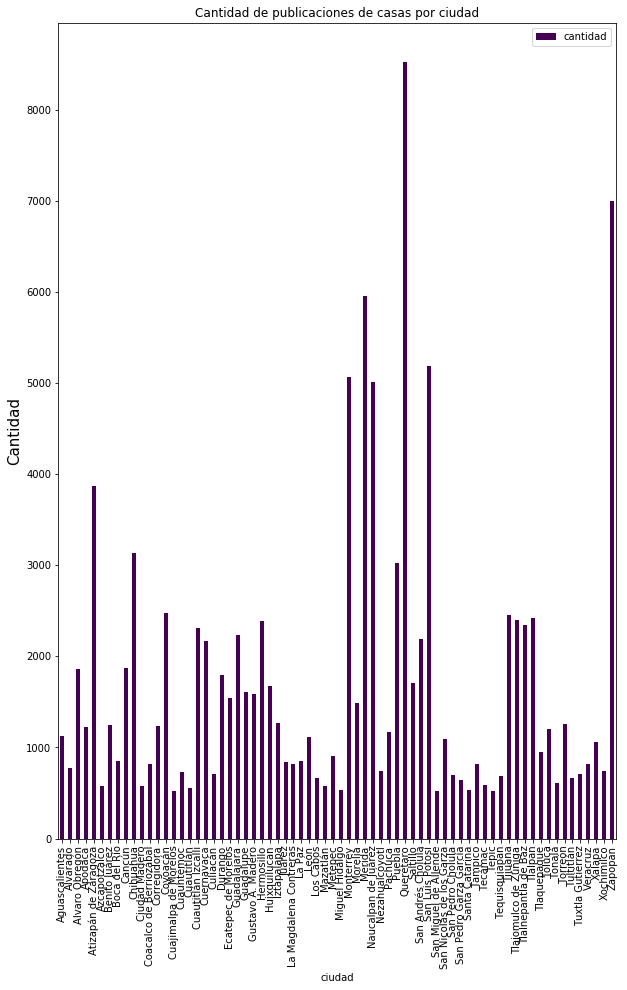

In [347]:
groupCiudadCant.loc[groupCiudadCant["cantidad"] > 500].plot.bar(x="ciudad", y="cantidad", rot=90, title = "Cantidad de publicaciones de casas por ciudad",colormap='viridis', figsize=(10,15)).set_ylabel("Cantidad", fontsize=15)

In [348]:
ciudadPrecioCantidadGroup = casaPrecioCiudad.groupby(casaPrecioCiudad["ciudad"]).agg({"precio": "count"}).reset_index()
ciudadPrecioCantidadGroup.columns = ["ciudad", "cantidad"]
ciudadPrecioCantidadGroup = ciudadPrecioCantidadGroup.loc[groupCiudadCant["cantidad"] > 800]
ciudadPrecioCantidadGroup.head()

,ciudad,cantidad
15,Aguascalientes,1131
27,Alvaro Obregón,1866
43,Apodaca,1221
56,Atizapán de Zaragoza,3876
73,Benito Juárez,1250


In [349]:
CasaPrecioCiudadCantidad = casaPrecioCiudad.merge(ciudadPrecioCantidadGroup, how="right", on = "ciudad")
display(CasaPrecioCiudadCantidad.head())

,ciudad,precio,cantidad
0,San Luis Potosí,488000.00,5192
1,San Luis Potosí,2600000.00,5192
2,San Luis Potosí,2200000.00,5192
3,San Luis Potosí,710000.00,5192
4,San Luis Potosí,3880000.00,5192


Text(0.5, 1.0, 'Precios de casas en distintas ciudades')

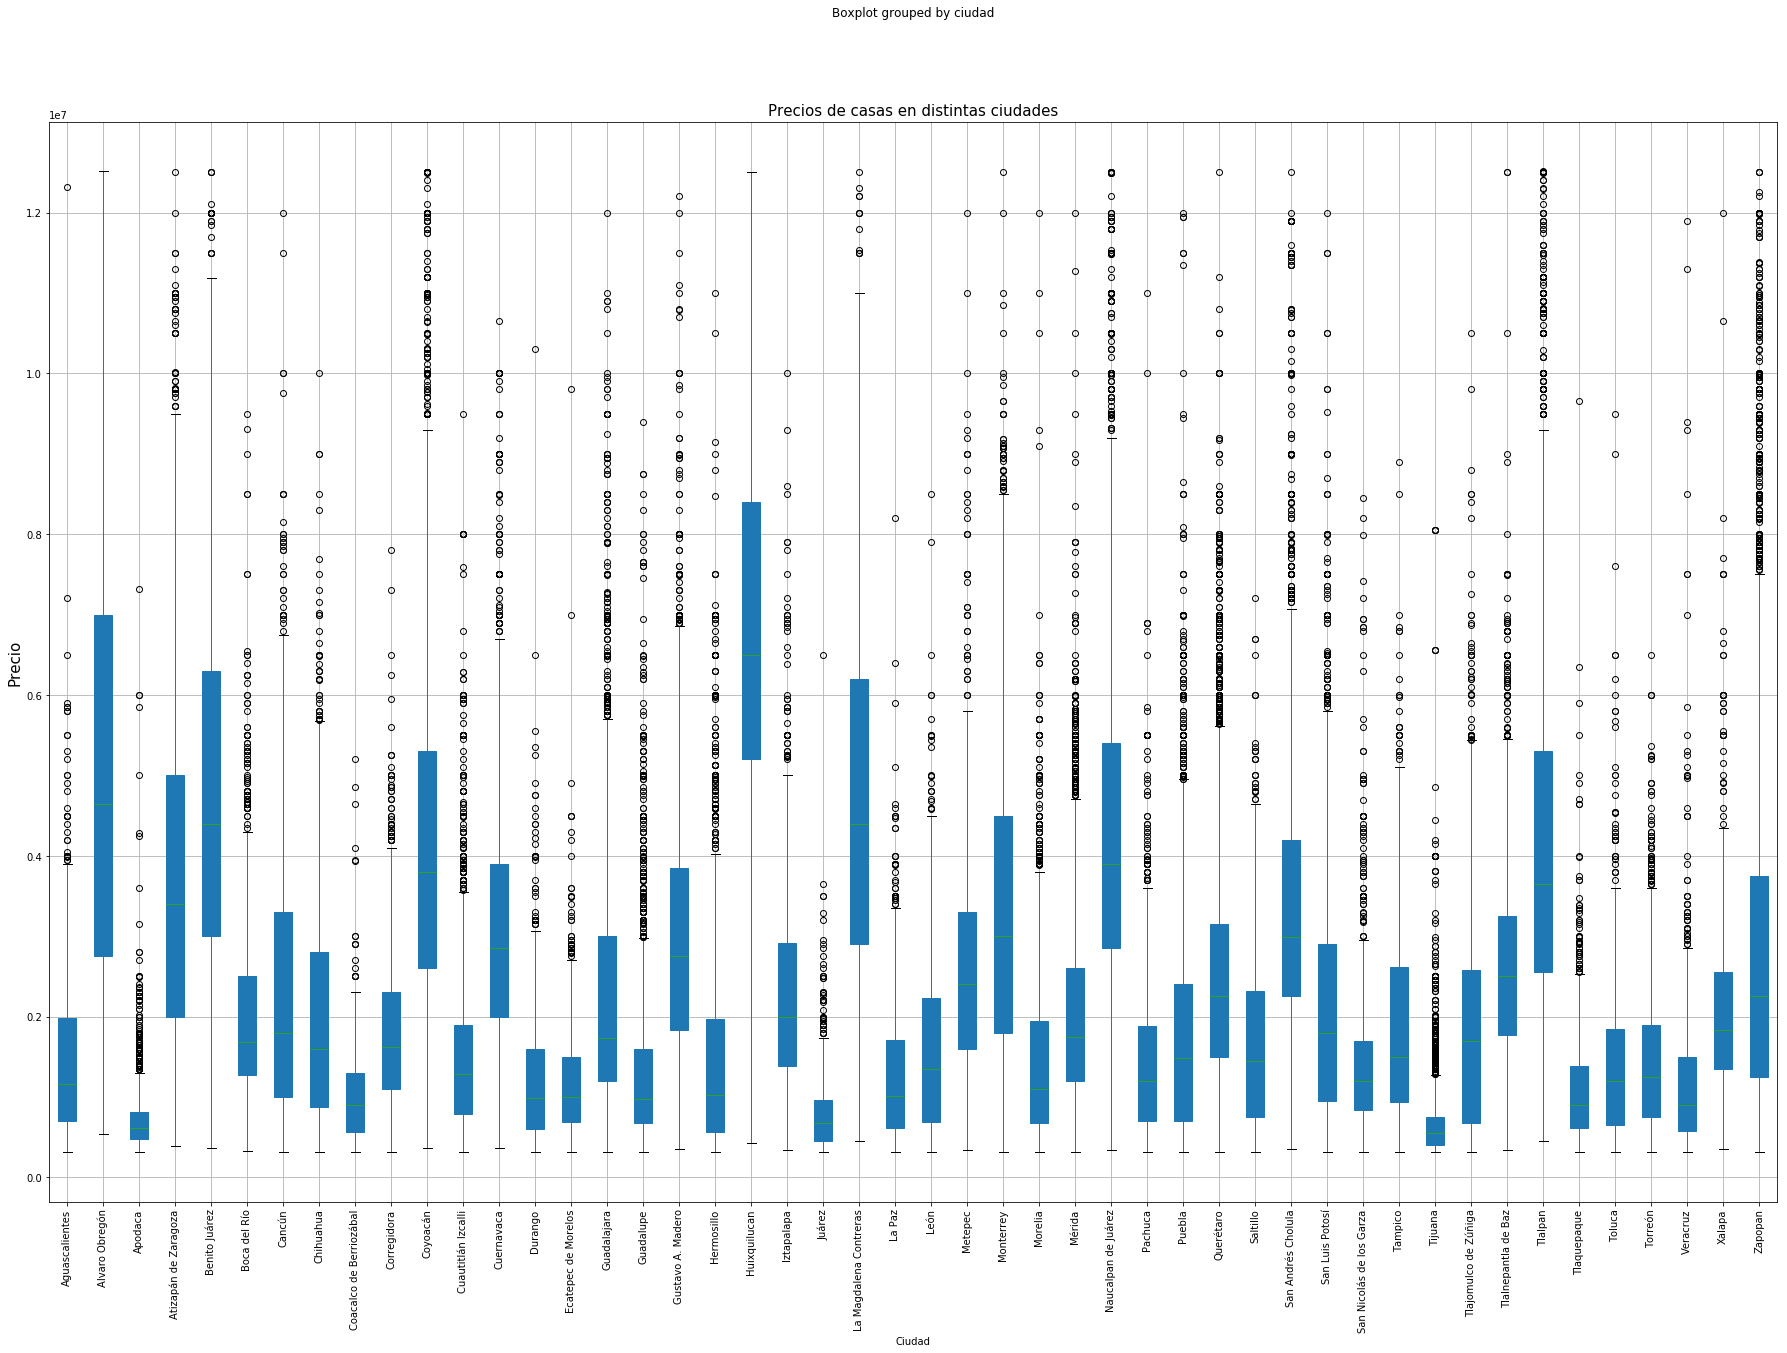

In [350]:
casaPrecioCiudadBoxPlot = CasaPrecioCiudadCantidad.boxplot(column=["precio"],rot = 90, patch_artist=True, figsize=(30,20), by=["ciudad"])
casaPrecioCiudadBoxPlot.set_xlabel("Ciudad")
casaPrecioCiudadBoxPlot.set_ylabel("Precio", fontsize=15)
casaPrecioCiudadBoxPlot.set_title("Precios de casas en distintas ciudades", fontsize=15)

## ¿El precio está relacionado a la cantidad de publicaciones?

In [351]:
CasaPrecioCiudadCantidad.head()

,ciudad,precio,cantidad
0,San Luis Potosí,488000.00,5192
1,San Luis Potosí,2600000.00,5192
2,San Luis Potosí,2200000.00,5192
3,San Luis Potosí,710000.00,5192
4,San Luis Potosí,3880000.00,5192


In [352]:
CasaPrecioCiudadCantidad["precio"].corr(CasaPrecioCiudadCantidad["cantidad"])

0.08018219284394552

**Parece que no se relaciona el precio con la cantidad**

## Ciudad con precio más caro por metro cuadrado

In [353]:
casaPrecioMetroCuadrado = casas.iloc[:, [5,22, 12]]
casaPrecioMetroCuadrado['PrecioPorMetroCuadrado'] = np.divide(casaPrecioMetroCuadrado['precio'], casaPrecioMetroCuadrado['metrostotales'])
casaPrecioMetroCuadrado.nlargest(10, "PrecioPorMetroCuadrado")

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ciudad,precio,metrostotales,PrecioPorMetroCuadrado
33462,Texcoco,9700000.00,15.00,646666.67
7118,Allende,10000000.00,21.00,476190.48
64673,Chihuahua,8500000.00,20.00,425000.00
93736,San Miguel de Allende,8862000.00,25.00,354480.00
14144,Torreón,4600000.00,16.00,287500.00
160479,Boca del Río,7500000.00,29.00,258620.69
19407,Torreón,4000000.00,16.00,250000.00
204710,Torreón,3650000.00,15.00,243333.33
177816,Torreón,3450000.00,15.00,230000.00
86187,Torreón,4450000.00,20.00,222500.00


Text(0.5, 1.0, 'Precios por metro cuadrado en distintas ciudades')

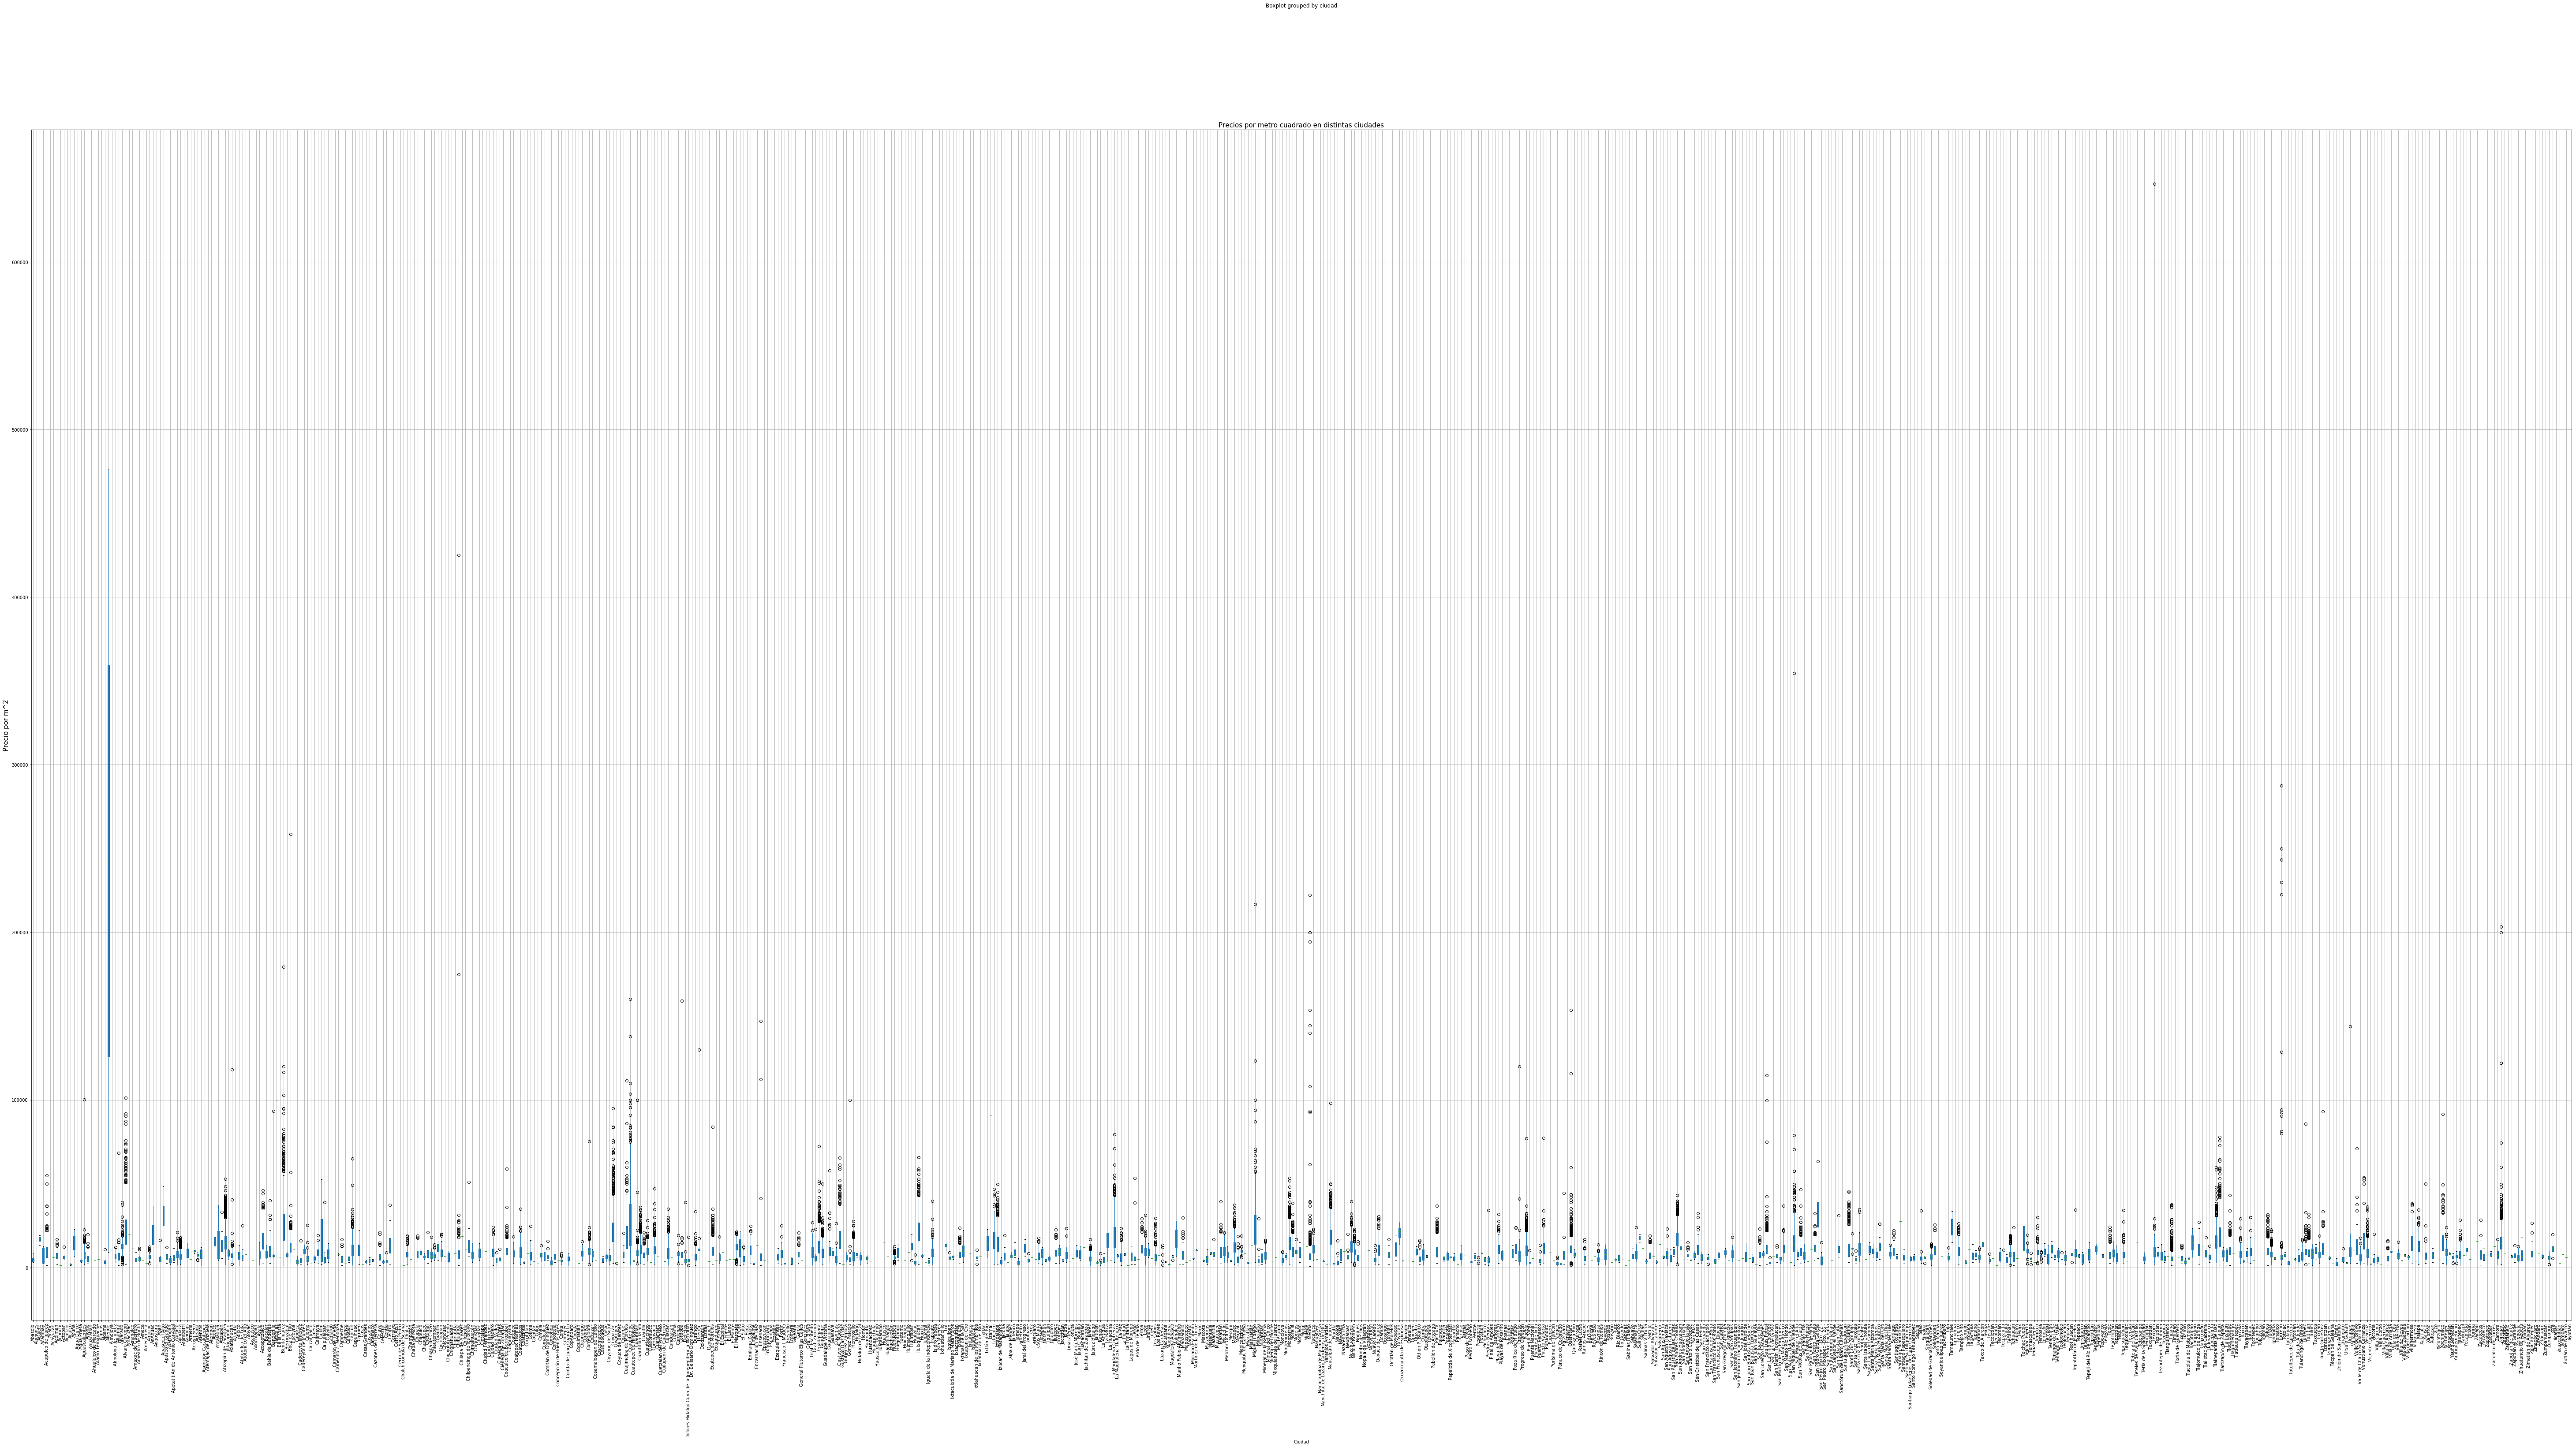

In [354]:
casaPrecioMetroCuadradoBoxPlot = casaPrecioMetroCuadrado.boxplot(column=["PrecioPorMetroCuadrado"],rot = 90, patch_artist=True, figsize=(100,50), by=["ciudad"])
casaPrecioMetroCuadradoBoxPlot.set_xlabel("Ciudad")
casaPrecioMetroCuadradoBoxPlot.set_ylabel("Precio por m^2", fontsize=15)
casaPrecioMetroCuadradoBoxPlot.set_title("Precios por metro cuadrado en distintas ciudades", fontsize=15)

Hay algunas ciudades que están por arriba de otras en terminos de precios, habrá que encontrar una manera de rankearlas

## Scatter plot precio por latitud

In [355]:
casaPrecioLat = casas.iloc[:, [22, 14, 15]]
casaPrecioLat.head()

,precio,lat,lng
2,1200000.00,nan,nan
3,650000.00,19.30,-99.69
6,1150000.00,17.14,-96.80
7,4200000.00,20.67,-87.04
10,488000.00,22.20,-101.02


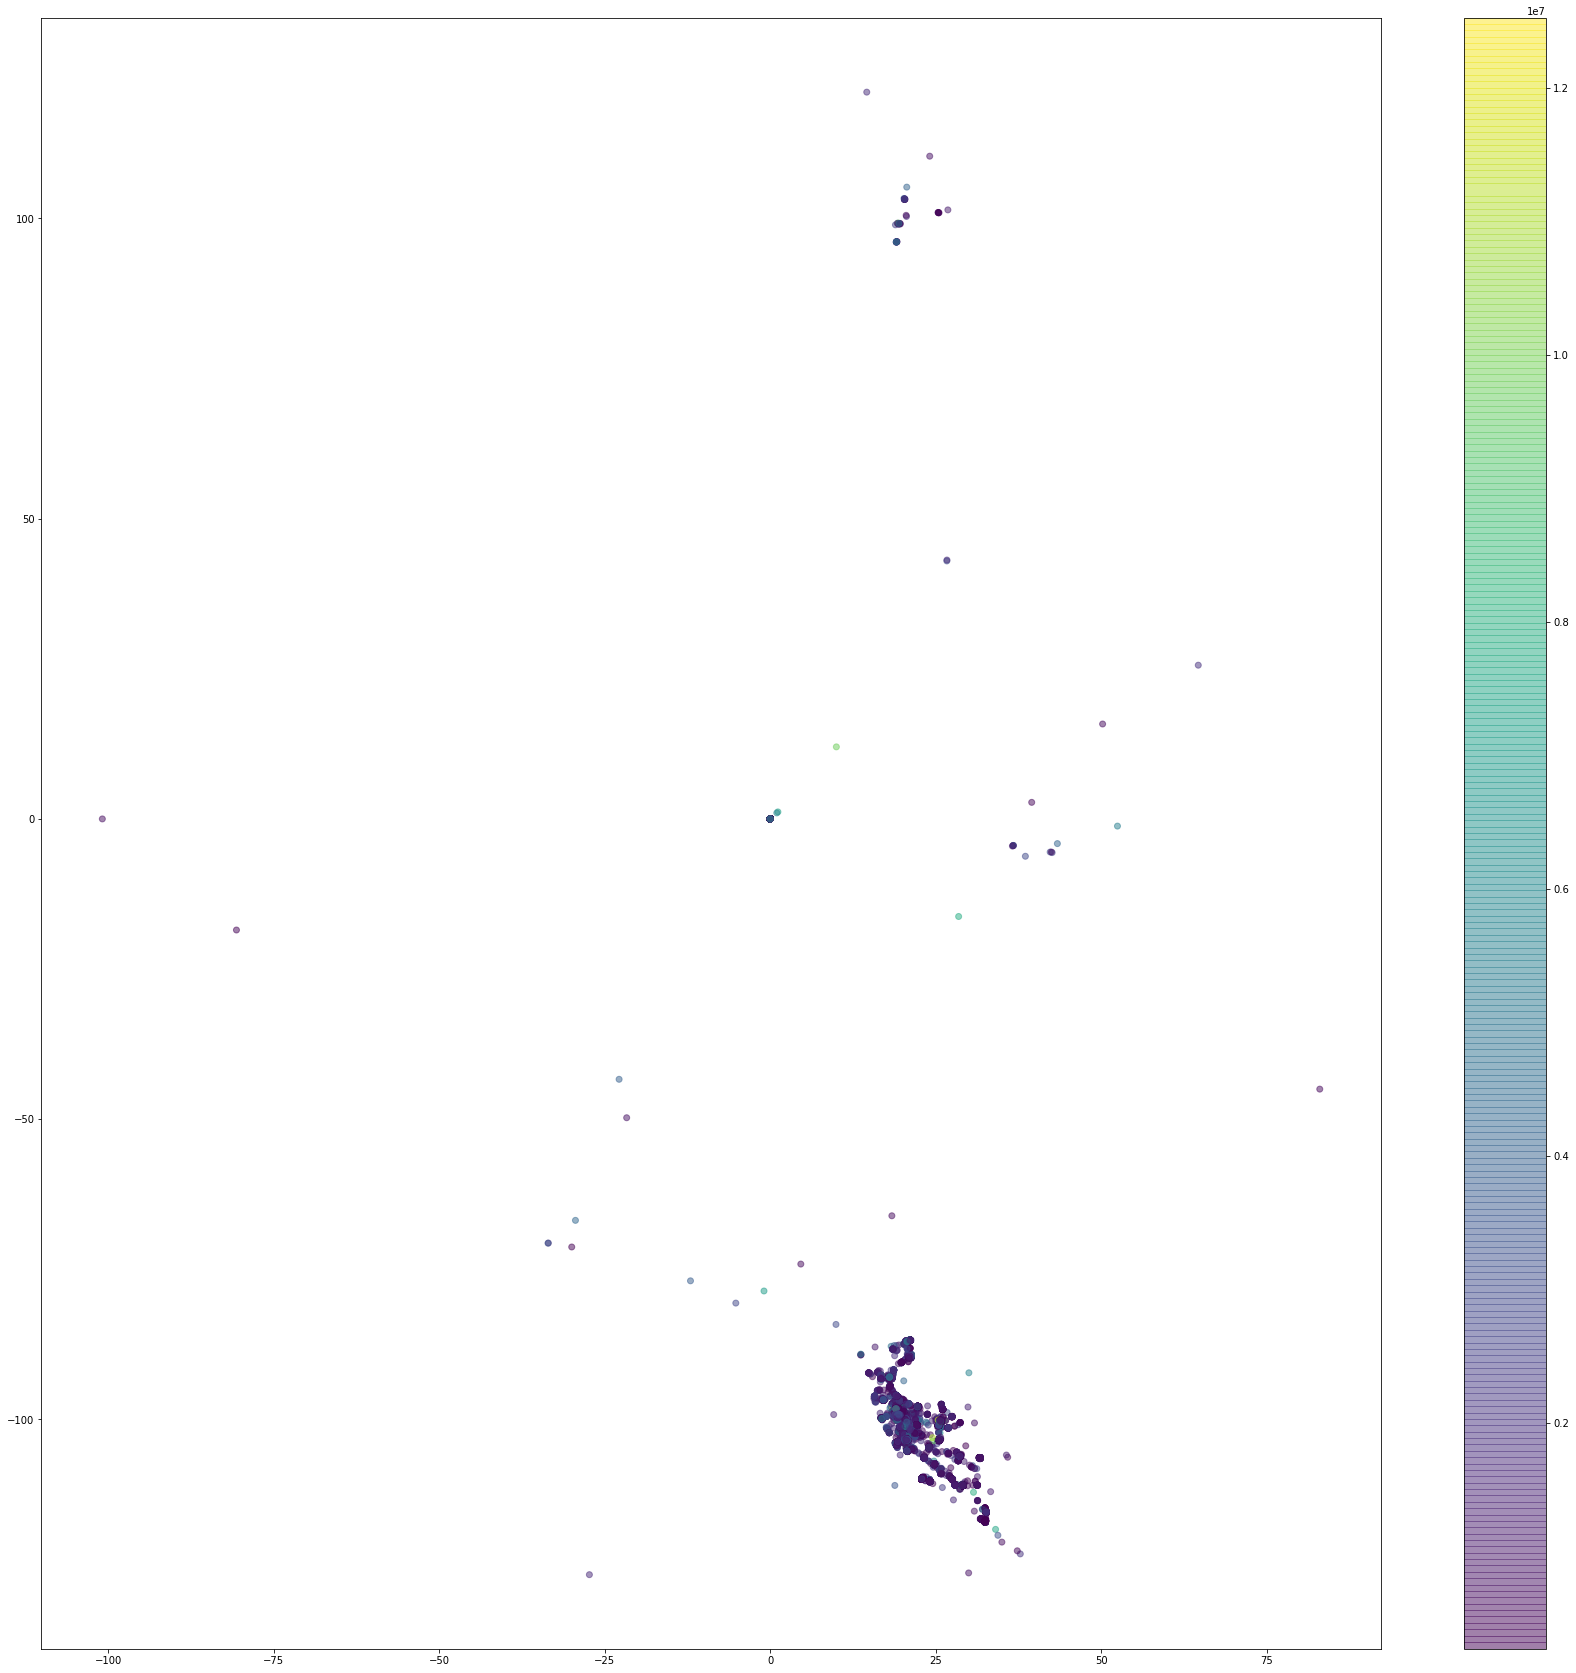

In [356]:
plt.figure(figsize=(30,30))
plt.scatter(casaPrecioLat["lat"], casaPrecioLat["lng"], c=casaPrecioLat["precio"],alpha=0.5)
plt.colorbar()
plt.show()

Esto aporta nada